
# Algoritmo Genético para o Problema da Mochila usando DEAP

Este notebook demonstra uma implementação moderna do problema clássico da **Mochila (Knapsack)** utilizando a biblioteca **[DEAP](https://deap.readthedocs.io/)**.  
O problema consiste em selecionar itens com diferentes valores e pesos para maximizar o valor total, respeitando uma capacidade máxima da mochila.


In [139]:

# Instalar DEAP (se necessário)
# !pip install deap


In [140]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools
import pandas as pd
from random import sample


# Configuração para gráficos no notebook
%matplotlib inline


In [ ]:
    # Definição manual dos itens (valor, peso)
itens = [
    (60, 1.3),   # Livro 1: valor R$ 60, peso 1.3 kg
    (100, 2.0),  # Livro 2: valor R$ 100, peso 2.0 kg
    (120, 3.0),  # Livro 3: valor R$ 120, peso 3.0 kg
    (80, 1.5),   # Livro 4: valor R$ 80, peso 1.5 kg
    (30, 0.5),   # Livro 5: valor R$ 30, peso 0.5 kg
    (90, 1.2),   # Livro 6: valor R$ 90, peso 1.2 kg
    (70, 0.8)    # Livro 7: valor R$ 70, peso 0.8 kg
]
CAPACIDADE = 6  # Capacidade máxima da mochila em kg
NUM_GENES = len(itens)

print(f"Itens carregados: {itens}")
print(f"Capacidade da mochila: {CAPACIDADE}")

Itens carregados: [(60, 1.3), (100, 2.0), (120, 3.0), (80, 1.5), (30, 0.5), (90, 1.2), (70, 0.8)]
Capacidade da mochila: 6


In [142]:
# Criar classes de Fitness e Indivíduo
creator.create("Fitness", base.Fitness, weights=(1.0,))  # Maximização
creator.create("Individuo", list, fitness=creator.Fitness)

toolbox = base.Toolbox()

# Inicialização dos indivíduos: lista de 0s e 1s (binário)
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individuo", tools.initRepeat, creator.Individuo, toolbox.attr_bool, n=NUM_GENES)
toolbox.register("populacao", tools.initRepeat, list, toolbox.individuo)


In [143]:

def avaliar(individuo):
    valor = 0
    peso = 0
    for gene, (v, p) in zip(individuo, itens):
        if gene == 1:
            valor += v
            peso += p
    if peso > CAPACIDADE:
        return 0,  # Penalização por ultrapassar capacidade
    return valor,

toolbox.register("evaluate", avaliar)


In [144]:

toolbox.register("mate", tools.cxTwoPoint)      # Crossover de 2 pontos
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)  # Mutação bit-flip
toolbox.register("select", tools.selTournament, tournsize=3)  # Seleção por torneio


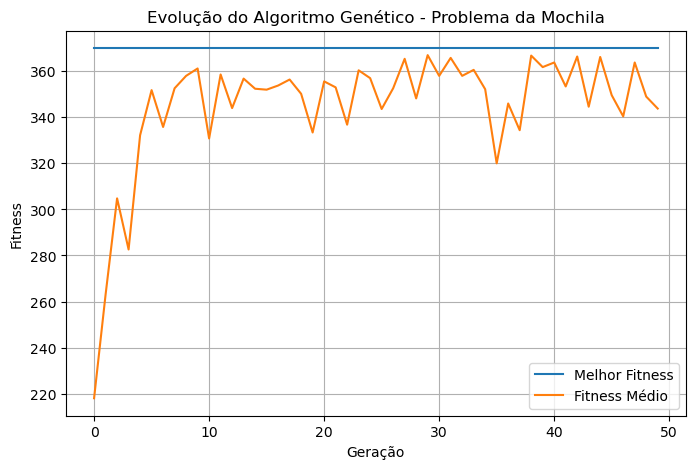

In [145]:

# Parâmetros do AG
TAM_POP = 50
NUM_GER = 50
PROB_CROSS = 0.7
PROB_MUT = 0.2

pop = toolbox.populacao(n=TAM_POP)

# Avaliar população inicial
for ind in pop:
    ind.fitness.values = toolbox.evaluate(ind)

melhores = []
medias = []

for ger in range(NUM_GER):
    filhos = toolbox.select(pop, len(pop))
    filhos = list(map(toolbox.clone, filhos))
    
    # Crossover
    for c1, c2 in zip(filhos[::2], filhos[1::2]):
        if random.random() < PROB_CROSS:
            toolbox.mate(c1, c2)
            del c1.fitness.values
            del c2.fitness.values
    
    # Mutação
    for mutante in filhos:
        if random.random() < PROB_MUT:
            toolbox.mutate(mutante)
            del mutante.fitness.values
    
    # Avaliar indivíduos inválidos
    invalidos = [ind for ind in filhos if not ind.fitness.valid]
    for ind in invalidos:
        ind.fitness.values = toolbox.evaluate(ind)
    
    # Atualizar população
    pop[:] = filhos
    
    # Estatísticas
    fits = [ind.fitness.values[0] for ind in pop]
    melhores.append(max(fits))
    medias.append(np.mean(fits))

# Plotar evolução
plt.figure(figsize=(8,5))
plt.plot(melhores, label="Melhor Fitness")
plt.plot(medias, label="Fitness Médio")
plt.xlabel("Geração")
plt.ylabel("Fitness")
plt.title("Evolução do Algoritmo Genético - Problema da Mochila")
plt.legend()
plt.grid()
plt.show()

In [146]:

melhor = tools.selBest(pop, k=1)[0]
print("Melhor solução encontrada:", melhor)
print("Valor:", avaliar(melhor)[0])
print("Peso:", sum([p for gene,(v,p) in zip(melhor,itens) if gene==1]))


Melhor solução encontrada: [0, 1, 0, 1, 1, 1, 1]
Valor: 370
Peso: 6.0
